In [1]:
#import libraries
!pip install folium
!pip install geopy
!pip install yellowbrick

import folium
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import io
import matplotlib.cm as cm
import matplotlib.colors as colors
import numpy as np 
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
print('Libraries imported.')

Libraries imported.


In [2]:
#import, clean, process, and display data
#read dataframe
df = pd.read_html('https://github.com/cjmarino/Coursera_Capstone_Final/blob/master/Akron_Ohio_Zip_Codes.csv', index_col=0)[0]
#reset index
df = df.reset_index(drop=True)
df.head()


,Zip Code,City,Latitude,Longitude
0,44203,"Barberton, New Franklin, Norton",41.0274,-81.6364
1,44221,"Cuyahoga Falls, Stow",41.1362,-81.4828
2,44223,"Cuyahoga Falls, Akron",41.1740,-81.5212
3,44260,"Mogadore, Saint Joseph, Suffield",41.0263,-81.3509
4,44278,"Tallmadge, Stow",41.0913,-81.4169


In [3]:
#In the last cell of your dataframe, use the .shape method to print the number of rows of your dataframe.
print('Number of rows in dataframe: ',df.shape[0])

Number of rows in dataframe:  20


In [5]:
# The code was removed by Watson Studio for sharing.

Your Foursquare credentials have been received: credentials are hidden.


In [6]:
#get geographical info of Akron
address = 'Akron, OH'

geolocator = Nominatim(user_agent="akron_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Akron are {}, {}. The following shows points in the areas surrounding Akron, OH.'.format(latitude, longitude))

# create map of Manhattan using latitude and longitude values
map_akron = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(df['Latitude'], df['Longitude'], df['City']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_akron)  
map_akron

The geograpical coordinate of Akron are 41.083064, -81.518485. The following shows points in the areas surrounding Akron, OH.


In [7]:
#get values of first city
df.loc[0, 'City']
city_latitude = df.loc[0, 'Latitude'] # city latitude value
city_longitude = df.loc[0, 'Longitude'] # city longitude value

city_name = df.loc[0, 'City'] # city name

print('Latitude and longitude values of {} are {}, {}.'.format(city_name, 
                                                               city_latitude, 
                                                               city_longitude))

Latitude and longitude values of Barberton, New Franklin, Norton are 41.0274, -81.6364.


In [8]:
#create GET request URL, send request an examine results
LIMIT = 100 # limit of number of venues returned by Foursquare API

#
radius = 500 # define radius

# # create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    city_latitude, 
    city_longitude, 
    radius, 
    LIMIT)
url # display URL
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5fc3e9129e7d3348a3b7ecac'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Norton',
  'headerFullLocation': 'Norton',
  'headerLocationGranularity': 'city',
  'totalResults': 21,
  'suggestedBounds': {'ne': {'lat': 41.0319000045, 'lng': -81.63044609257493},
   'sw': {'lat': 41.0228999955, 'lng': -81.64235390742506}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4d33946eeefa8cfa96a442b3',
       'name': 'Charger Lanes',
       'location': {'address': '1213 Norton Ave',
        'lat': 41.026438326378596,
        'lng': -81.63381402160235,
        'labeledLatLngs': [{'label': 'display',
          'lat': 41.026438326378596,
          'lng': -81.

In [9]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [10]:
#clean json and structure it into pandas dataframe
venues = results['response']['groups'][0]['items']
    
nearby_venues = pd.json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Charger Lanes,Bowling Alley,41.026438,-81.633814
1,Sweet Henrie's,Diner,41.024749,-81.637235
2,SUBWAY,Sandwich Place,41.028387,-81.637436
3,Chase Bank,Bank,41.025024,-81.637916
4,Dollar General,Discount Store,41.024201,-81.640551


In [11]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

21 venues were returned by Foursquare.


In [12]:
#create function to repeat with all neighborhoods in akron
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                  'City Latitude', 
                  'City Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [13]:
#call function for toronto venues
akron_venues = getNearbyVenues(names=df['City'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

Barberton, New Franklin, Norton
Cuyahoga Falls, Stow
Cuyahoga Falls, Akron
Mogadore, Saint Joseph, Suffield
Tallmadge, Stow
Akron
Akron
Akron
Akron
Akron
Akron
Akron
Akron
Akron
Akron, Green, Lakemore
Akron, Cuyahoga Falls, Fairlawn, Botzum
Akron
Akron, New Franklin, Portage Lakes, Green
Akron, Norton
Akron, Fairlawn, Cuyahoga Falls, Bath, Montrose-Ghent, Ghent


In [14]:
#check size of resulting dataframe
print(akron_venues.shape)
akron_venues.head()

(149, 7)


,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Barberton, New Franklin, Norton",41.0274,-81.6364,Charger Lanes,41.026438,-81.633814,Bowling Alley
1,"Barberton, New Franklin, Norton",41.0274,-81.6364,Sweet Henrie's,41.024749,-81.637235,Diner
2,"Barberton, New Franklin, Norton",41.0274,-81.6364,SUBWAY,41.028387,-81.637436,Sandwich Place
3,"Barberton, New Franklin, Norton",41.0274,-81.6364,Chase Bank,41.025024,-81.637916,Bank
4,"Barberton, New Franklin, Norton",41.0274,-81.6364,Dollar General,41.024201,-81.640551,Discount Store


In [15]:
#check how many venues were returned for each city
akron_venues.groupby('City').count()

,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
City,,,,,,
Akron,58,58,58,58,58,58
"Akron, Cuyahoga Falls, Fairlawn, Botzum",1,1,1,1,1,1
"Akron, Fairlawn, Cuyahoga Falls, Bath, Montrose-Ghent, Ghent",2,2,2,2,2,2
"Akron, Green, Lakemore",4,4,4,4,4,4
"Akron, New Franklin, Portage Lakes, Green",11,11,11,11,11,11
"Akron, Norton",4,4,4,4,4,4
"Barberton, New Franklin, Norton",21,21,21,21,21,21
"Cuyahoga Falls, Stow",41,41,41,41,41,41
"Mogadore, Saint Joseph, Suffield",7,7,7,7,7,7


In [16]:
#find out how many unique categories were pulled
print('There are {} uniques categories.'.format(len(akron_venues['Venue Category'].unique())))

There are 73 uniques categories.


In [18]:
#analyze each city
# one hot encoding
akron_onehot = pd.get_dummies(akron_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
akron_onehot['City'] = akron_venues['City'] 

# move neighborhood column to the first column
fixed_columns = [akron_onehot.columns[-1]] + list(akron_onehot.columns[:-1])
akron_onehot = akron_onehot[fixed_columns]

akron_onehot.head()

,City,Accessories Store,American Restaurant,Antique Shop,Art Gallery,Arts & Crafts Store,Automotive Shop,Bank,Bar,Beer Garden,Bowling Alley,Candy Store,Chinese Restaurant,Clothing Store,Coffee Shop,Construction & Landscaping,Convenience Store,Cosmetics Shop,Dance Studio,Diner,Discount Store,Dog Run,Donut Shop,Dry Cleaner,Electronics Store,Farm,Farmers Market,Fast Food Restaurant,Food Truck,Furniture / Home Store,Garden,Gas Station,Gift Shop,Golf Course,Grocery Store,Gym,Gym / Fitness Center,Health & Beauty Service,Historic Site,Home Service,Hot Spring,Hotel,Ice Cream Shop,Imported Food Shop,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Lake,Laundromat,Lighthouse,Liquor Store,Lounge,Movie Theater,New American Restaurant,Park,Peruvian Restaurant,Pharmacy,Pizza Place,Playground,Plaza,Pool,Rafting,Restaurant,Sandwich Place,Shipping Store,Skating Rink,Speakeasy,Tennis Court,Theme Park,Toy / Game Store,Trail,Travel & Transport,Wine Bar
0,"Barberton, New Franklin, Norton",0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"Barberton, New Franklin, Norton",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"Barberton, New Franklin, Norton",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,"Barberton, New Franklin, Norton",0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,"Barberton, New Franklin, Norton",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [284]:
#examine dataframe shape
akron_onehot.shape

(149, 74)

In [19]:
#group rows by city and take mean of the frequency of occurence of each category
akron_grouped = akron_onehot.groupby('City').mean().reset_index()
akron_grouped

,City,Accessories Store,American Restaurant,Antique Shop,Art Gallery,Arts & Crafts Store,Automotive Shop,Bank,Bar,Beer Garden,Bowling Alley,Candy Store,Chinese Restaurant,Clothing Store,Coffee Shop,Construction & Landscaping,Convenience Store,Cosmetics Shop,Dance Studio,Diner,Discount Store,Dog Run,Donut Shop,Dry Cleaner,Electronics Store,Farm,Farmers Market,Fast Food Restaurant,Food Truck,Furniture / Home Store,Garden,Gas Station,Gift Shop,Golf Course,Grocery Store,Gym,Gym / Fitness Center,Health & Beauty Service,Historic Site,Home Service,Hot Spring,Hotel,Ice Cream Shop,Imported Food Shop,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Lake,Laundromat,Lighthouse,Liquor Store,Lounge,Movie Theater,New American Restaurant,Park,Peruvian Restaurant,Pharmacy,Pizza Place,Playground,Plaza,Pool,Rafting,Restaurant,Sandwich Place,Shipping Store,Skating Rink,Speakeasy,Tennis Court,Theme Park,Toy / Game Store,Trail,Travel & Transport,Wine Bar
0,Akron,0.00000,0.034483,0.00000,0.00000,0.00000,0.00000,0.000000,0.086207,0.00000,0.000000,0.017241,0.034483,0.017241,0.017241,0.000000,0.086207,0.017241,0.000000,0.000000,0.000000,0.017241,0.017241,0.000000,0.051724,0.0,0.000000,0.051724,0.017241,0.017241,0.000000,0.034483,0.000000,0.00,0.034483,0.017241,0.034483,0.0,0.000000,0.017241,0.000000,0.00000,0.00000,0.017241,0.00000,0.00000,0.00000,0.017241,0.000000,0.017241,0.017241,0.000000,0.017241,0.017241,0.017241,0.051724,0.00000,0.017241,0.051724,0.017241,0.00000,0.000000,0.00000,0.00000,0.017241,0.017241,0.00000,0.017241,0.017241,0.000000,0.017241,0.017241,0.017241,0.000000
1,"Akron, Cuyahoga Falls, Fairlawn, Botzum",0.00000,0.000000,0.00000,0.00000,0.00000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,"Akron, Fairlawn, Cuyahoga Falls, Bath, Montros...",0.00000,0.000000,0.00000,0.00000,0.00000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.50000,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,"Akron, Green, Lakemore",0.00000,0.000000,0.00000,0.00000,0.00000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.00000,0.00000,0.00000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.00000,0.000000,0.250000,0.000000,0.00000,0.000000,0.00000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,"Akron, New Franklin, Portage Lakes, Green",0.00000,0.000000,0.00000,0.00000,0.00000,0.00000,0.000000,0.090909,0.00000,0.090909,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.090909,0.000000,0.0,0.090909,0.000000,0.000000,0.000000,0.090909,0.000000,0.090909,0.00,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.090909,0.00000,0.00

In [20]:
#confirm new shape
akron_grouped.shape

(9, 74)

In [22]:
#print each city along w top 5 most common venues
num_top_venues = 5

for hood in akron_grouped['City']:
    print("----"+hood+"----")
    temp = akron_grouped[akron_grouped['City'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Akron----
               venue  freq
0                Bar  0.09
1  Convenience Store  0.09
2  Electronics Store  0.05
3        Pizza Place  0.05
4               Park  0.05


----Akron, Cuyahoga Falls, Fairlawn, Botzum----
                     venue  freq
0  Health & Beauty Service   1.0
1            Historic Site   0.0
2  New American Restaurant   0.0
3            Movie Theater   0.0
4                   Lounge   0.0


----Akron, Fairlawn, Cuyahoga Falls, Bath, Montrose-Ghent, Ghent----
               venue  freq
0     Ice Cream Shop   0.5
1               Farm   0.5
2  Accessories Store   0.0
3               Lake   0.0
4      Movie Theater   0.0


----Akron, Green, Lakemore----
               venue  freq
0               Lake  0.25
1        Pizza Place  0.25
2  Convenience Store  0.25
3               Park  0.25
4  Accessories Store  0.00


----Akron, New Franklin, Portage Lakes, Green----
           venue  freq
0       Wine Bar  0.09
1  Bowling Alley  0.09
2           Lake  0.09
3   

In [23]:
#write function to sort venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [24]:
#create new dataframe and display top 10 venues for each city
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['City']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
akron_venues_sorted = pd.DataFrame(columns=columns)
akron_venues_sorted['City'] = akron_grouped['City']

for ind in np.arange(akron_grouped.shape[0]):
    akron_venues_sorted.iloc[ind, 1:] = return_most_common_venues(akron_grouped.iloc[ind, :], num_top_venues)

akron_venues_sorted.head()

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Akron,Convenience Store,Bar,Electronics Store,Fast Food Restaurant,Park,Pizza Place,Gym / Fitness Center,Chinese Restaurant,Gas Station,Grocery Store
1,"Akron, Cuyahoga Falls, Fairlawn, Botzum",Health & Beauty Service,Gym / Fitness Center,Discount Store,Dog Run,Donut Shop,Dry Cleaner,Electronics Store,Farm,Farmers Market,Fast Food Restaurant
2,"Akron, Fairlawn, Cuyahoga Falls, Bath, Montros...",Ice Cream Shop,Farm,Wine Bar,Fast Food Restaurant,Dog Run,Donut Shop,Dry Cleaner,Electronics Store,Farmers Market,Food Truck
3,"Akron, Green, Lakemore",Park,Convenience Store,Pizza Place,Lake,Wine Bar,Diner,Dog Run,Donut Shop,Dry Cleaner,Electronics Store
4,"Akron, New Franklin, Portage Lakes, Green",Wine Bar,Bar,Lake,Pharmacy,Dry Cleaner,Pool,Farmers Market,Bowling Alley,Hot Spring,Garden


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


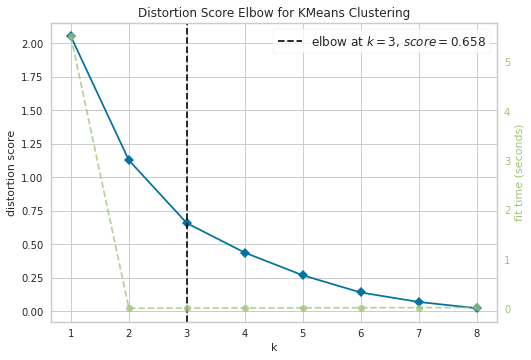

In [25]:
akron_part_clustering = akron_grouped.drop('City', 1)
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,9))

visualizer.fit(akron_part_clustering)
visualizer.poof()


In [26]:
#cluster neighborhoods
# set number of clusters
kclusters = 7

akron_grouped_clustering = akron_grouped.drop('City', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(akron_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 
akron_venues_sorted.head(100)

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Akron,Convenience Store,Bar,Electronics Store,Fast Food Restaurant,Park,Pizza Place,Gym / Fitness Center,Chinese Restaurant,Gas Station,Grocery Store
1,"Akron, Cuyahoga Falls, Fairlawn, Botzum",Health & Beauty Service,Gym / Fitness Center,Discount Store,Dog Run,Donut Shop,Dry Cleaner,Electronics Store,Farm,Farmers Market,Fast Food Restaurant
2,"Akron, Fairlawn, Cuyahoga Falls, Bath, Montros...",Ice Cream Shop,Farm,Wine Bar,Fast Food Restaurant,Dog Run,Donut Shop,Dry Cleaner,Electronics Store,Farmers Market,Food Truck
3,"Akron, Green, Lakemore",Park,Convenience Store,Pizza Place,Lake,Wine Bar,Diner,Dog Run,Donut Shop,Dry Cleaner,Electronics Store
4,"Akron, New Franklin, Portage Lakes, Green",Wine Bar,Bar,Lake,Pharmacy,Dry Cleaner,Pool,Farmers Market,Bowling Alley,Hot Spring,Garden
5,"Akron, Norton",Farmers Market,Golf Course,Construction & Landscaping,Bar,Wine Bar,Dog Run,Donut Shop,Dry Cleaner,Electronics Store,Farm
6,"Barberton, New Franklin, Norton",Fast Food Restaurant,Pizza Place,Gift Shop,Pharmacy,Convenience Store,Bowling Alley,Discount Store,Diner,Dance Studio,Construction & Landscaping
7,"Cuyahoga Falls, Stow",American Restaurant,Hotel,Bank,Italian Restaurant,Plaza,Bar,Cosmetics Shop,Gym / Fitness Center,Antique Shop,Historic Site
8,"Mogadore, Saint Joseph, Suffield",Pizza Place,Liquor Store,Historic Site,Theme Park,Gas Station,Fast Food Restaurant,Wine Bar,Electronics Store,Discount Store,Dog Run


In [27]:
#create dataframe that includes the cluster & top 10 venues for each city
# add clustering labels
akron_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

akron_merged = df

# merge manhattan_grouped with akron_venues_sorted to add latitude/longitude for each city
akron_merged = akron_merged.join(akron_venues_sorted.set_index('City'), on='City')

akron_merged.head(15) # check the last columns!

,Zip Code,City,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,44203,"Barberton, New Franklin, Norton",41.0274,-81.6364,3.0,Fast Food Restaurant,Pizza Place,Gift Shop,Pharmacy,Convenience Store,Bowling Alley,Discount Store,Diner,Dance Studio,Construction & Landscaping
1,44221,"Cuyahoga Falls, Stow",41.1362,-81.4828,3.0,American Restaurant,Hotel,Bank,Italian Restaurant,Plaza,Bar,Cosmetics Shop,Gym / Fitness Center,Antique Shop,Historic Site
2,44223,"Cuyahoga Falls, Akron",41.1740,-81.5212,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,44260,"Mogadore, Saint Joseph, Suffield",41.0263,-81.3509,6.0,Pizza Place,Liquor Store,Historic Site,Theme Park,Gas Station,Fast Food Restaurant,Wine Bar,Electronics Store,Discount Store,Dog Run
4,44278,"Tallmadge, Stow",41.0913,-81.4169,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,44301,Akron,41.0440,-81.5212,3.0,Convenience Store,Bar,Electronics Store,Fast Food Restaurant,Park,Pizza Place,Gym / Fitness Center,Chinese Restaurant,Gas Station,Grocery Store
6,44302,Akron,41.0889,-81.5363,3.0,Convenience Store,Bar,Electronics Store,Fast Food Restaurant,Park,Pizza Place,Gym / Fitness Center,Chinese Restaurant,Gas Station,Grocery Store
7,44303,Akron,41.1026,-81.5350,3.0,Convenience Store,Bar,Electronics Store,Fast Food Restaurant,Park,Pizza Place,Gym / Fitness Center,Chinese Restaurant,Gas Station,Grocery Store
8,44304,Akron,41.0801,-81.5020,3.0,Convenience Store,Bar,Electronics Store,Fast Food Restaurant,Park,Pizza Place,Gym / Fitness Center,Chinese Restaurant,Gas Station,Grocery Store
9,44305,Akron,41.0746,-81.4609,3.0,Convenience Store,Bar,Electronics Store,Fast Food Restaurant,Park,Pizza Place,Gym / Fitness Center,Chinese Restaurant,Gas Station,Grocery Store


In [28]:
#visualize resulting clusters
# create map
akron_merged = akron_merged.dropna().reset_index()
akron_merged.head()
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(akron_merged['Latitude'], akron_merged['Longitude'], akron_merged['City'], akron_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        #color=rainbow[cluster-1],
        fill=True,
        #fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [29]:
#examine clusters
#cluster 1
akron_merged.loc[akron_merged['Cluster Labels'] == 0, akron_merged.columns[[1] + list(range(5, akron_merged.shape[1]))]]

,Zip Code,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,44312,0.0,Park,Convenience Store,Pizza Place,Lake,Wine Bar,Diner,Dog Run,Donut Shop,Dry Cleaner,Electronics Store


In [30]:
#examine clusters
#cluster 2
akron_merged.loc[akron_merged['Cluster Labels'] == 1, akron_merged.columns[[1] + list(range(5, akron_merged.shape[1]))]]

,Zip Code,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
13,44313,1.0,Health & Beauty Service,Gym / Fitness Center,Discount Store,Dog Run,Donut Shop,Dry Cleaner,Electronics Store,Farm,Farmers Market,Fast Food Restaurant


In [31]:
#examine clusters
#cluster 3
akron_merged.loc[akron_merged['Cluster Labels'] == 2, akron_merged.columns[[1] + list(range(5, akron_merged.shape[1]))]]

,Zip Code,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
17,44333,2.0,Ice Cream Shop,Farm,Wine Bar,Fast Food Restaurant,Dog Run,Donut Shop,Dry Cleaner,Electronics Store,Farmers Market,Food Truck


In [32]:
#examine clusters
#cluster 4
akron_merged.loc[akron_merged['Cluster Labels'] == 3, akron_merged.columns[[1] + list(range(5, akron_merged.shape[1]))]]

,Zip Code,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,44203,3.0,Fast Food Restaurant,Pizza Place,Gift Shop,Pharmacy,Convenience Store,Bowling Alley,Discount Store,Diner,Dance Studio,Construction & Landscaping
1,44221,3.0,American Restaurant,Hotel,Bank,Italian Restaurant,Plaza,Bar,Cosmetics Shop,Gym / Fitness Center,Antique Shop,Historic Site
3,44301,3.0,Convenience Store,Bar,Electronics Store,Fast Food Restaurant,Park,Pizza Place,Gym / Fitness Center,Chinese Restaurant,Gas Station,Grocery Store
4,44302,3.0,Convenience Store,Bar,Electronics Store,Fast Food Restaurant,Park,Pizza Place,Gym / Fitness Center,Chinese Restaurant,Gas Station,Grocery Store
5,44303,3.0,Convenience Store,Bar,Electronics Store,Fast Food Restaurant,Park,Pizza Place,Gym / Fitness Center,Chinese Restaurant,Gas Station,Grocery Store
6,44304,3.0,Convenience Store,Bar,Electronics Store,Fast Food Restaurant,Park,Pizza Place,Gym / Fitness Center,Chinese Restaurant,Gas Station,Grocery Store
7,44305,3.0,Convenience Store,Bar,Electronics Store,Fast Food Restaurant,Park,Pizza Place,Gym / Fitness Center,Chinese Restaurant,Gas Station,Grocery Store
8,44306,3.0,Convenience Store,Bar,Electronics Store,Fast Food Restaurant,Park,Pizza Place,Gym / Fitness Center,Chinese Restaurant,Gas Station,Grocery Store
9,44307,3.0,Convenience Store,Bar,Electronics Store,Fast Food Restaurant,Park,Pizza Place,Gym / Fitness Center,Chinese Restaurant,Gas Station,Grocery Store
10,44310,3.0,Convenience Store,Bar,Electronics Store,Fast Food Restaurant,Park,Pizza Place,Gym / Fitness Center,Chinese Restaurant,Gas Station,Grocery Store


In [33]:
#examine clusters
#cluster 5
akron_merged.loc[akron_merged['Cluster Labels'] == 4, akron_merged.columns[[1] + list(range(5, akron_merged.shape[1]))]]

,Zip Code,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
16,44320,4.0,Farmers Market,Golf Course,Construction & Landscaping,Bar,Wine Bar,Dog Run,Donut Shop,Dry Cleaner,Electronics Store,Farm


In [34]:
#examine clusters
#cluster 6
akron_merged.loc[akron_merged['Cluster Labels'] == 5, akron_merged.columns[[1] + list(range(5, akron_merged.shape[1]))]]

,Zip Code,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
15,44319,5.0,Wine Bar,Bar,Lake,Pharmacy,Dry Cleaner,Pool,Farmers Market,Bowling Alley,Hot Spring,Garden


In [35]:
#examine clusters
#cluster 7
akron_merged.loc[akron_merged['Cluster Labels'] == 6, akron_merged.columns[[1] + list(range(5, akron_merged.shape[1]))]]

,Zip Code,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,44260,6.0,Pizza Place,Liquor Store,Historic Site,Theme Park,Gas Station,Fast Food Restaurant,Wine Bar,Electronics Store,Discount Store,Dog Run
